# Single target notebook

Here I explore the single target exports from the saildrone survey

In [10]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import warnings
from scipy import stats
from progressBar import log_progress
from matplotlib import rcParams
warnings.filterwarnings('ignore')

In [4]:
def readTargetExports(files):
    hold = []
    for filename in log_progress(files,every=1):
        df = pd.read_csv(filename, index_col=None, header=0)
        df['datetime'] = pd.to_datetime(df["Ping_date"].astype(str)+' '+df["Ping_time"])
        hold.append(df)
    df = pd.concat(hold, axis=0, ignore_index=True)
    df = df.rename(index=str, columns={"Target_longitude": "targetLon","Target_latitude": "targetLat","Target_true_depth": "targetDepth","TS_comp":"targetTS"})
    df1 = df[["datetime","targetLon","targetLat","targetDepth","targetTS"]]
    df1 = df1.set_index("datetime")
    return df1

def targetDist(df):
    fig = plt.figure(figsize=(18,4))
    plt.subplot(131)
    plt.hist(df.targetTS, bins='auto');

    plt.subplot(132)
    df['days_since'] = (df.index - min(df.index)).astype('timedelta64[D]')
    jet= plt.get_cmap('plasma')
    colors = iter(jet(np.linspace(0,1,len(df.days_since.unique()))))
    for day in np.sort(df.days_since.unique()):
        curDay = df[df.days_since == day]
        n,x  = np.histogram(curDay.targetTS, bins='auto');
        bin_centers = 0.5*(x[1:]+x[:-1])
        plt.plot(bin_centers,n, color=next(colors))


    plt.subplot(133)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.days_since,df.targetTS)
    line = slope*df.days_since+intercept
    plt.plot(df.days_since, df.targetTS,'.')
    plt.plot(df.days_since, intercept + slope*df.days_since, 'r');
    geoffroyTS(min(line)), geoffroyTS(max(line)), geoffroyTS(np.median(line))
    
def anonTS(TS):
    length = 10**((TS+72.7)/21.8)
    return length
def geoffroyTS(TS):
    length = 10**((TS+65.13)/14.33)
    return length
def parkerstetterTS(TS):
    length = 10**((TS+60.78)/8.03)
    return length

## Literature TS relationships

From Anonymous:
- length = 10**((TS+72.7)/21.8)

From Geoffroy:
-  length = 10**((TS+65.13)/14.33)

From Sandi:
- length = 10**((TS+60.78)/8.03)

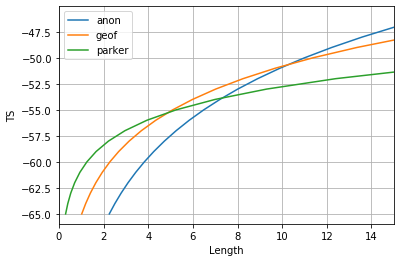

In [3]:
anon, geof, park = ([] for i in range(3))
for ts in range(-65, -45,1):
    anon.append(anonTS(ts))
    geof.append(geoffroyTS(ts))
    park.append(parkerstetterTS(ts))
plt.plot(anon, range(-65, -45,1))
plt.plot(geof, range(-65, -45,1))
plt.plot(park, range(-65, -45,1))
plt.grid()
plt.xlim([0,15])
plt.xlabel('Length')
plt.ylabel('TS');
plt.legend(['anon','geof','parker'])

Find and load in the targets that are both Sawada and frequency response filtered

In [20]:
targets1022 = glob('../../../data/EV/EVFiles/SD1022/exports/SingleTargetsNv*.csv')
df1022targets=readTargetExports(targets1022)
df1022targets['linearTS'] = 10**(df1022targets.targetTS/10)
print('There are '+str(len(df1022targets))+' targets in the 1022 dataset')

targets1023 = glob('../../../data/EV/EVFiles/SD1023/exports/SingleTargetsNv*.csv')
df1023targets=readTargetExports(targets1023)
df1023targets['linearTS'] = 10**(df1023targets.targetTS/10)
print('There are '+str(len(df1023targets))+' targets in the 1023 dataset')

There are 252755 targets in the 1022 dataset


There are 264752 targets in the 1023 dataset


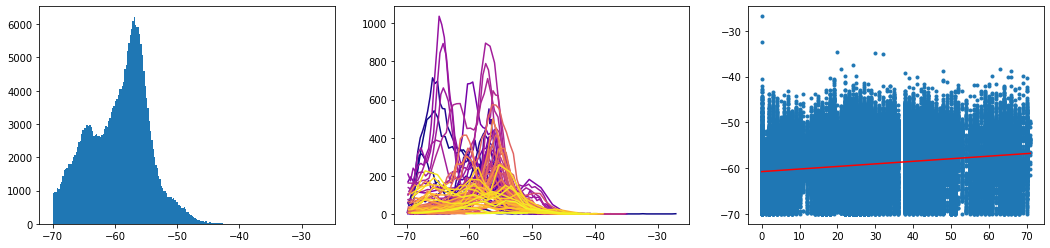

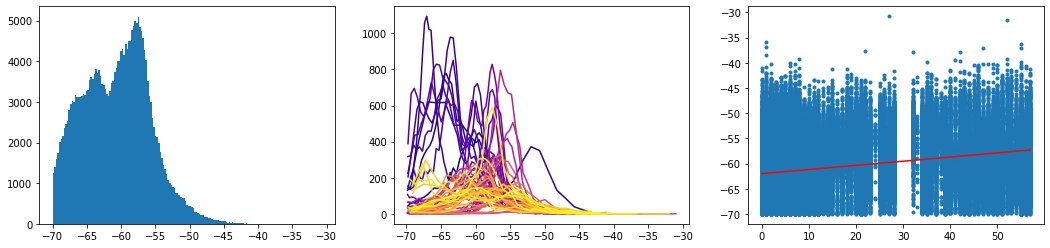

In [22]:
targetDist(df1023targets)
targetDist(df1022targets)

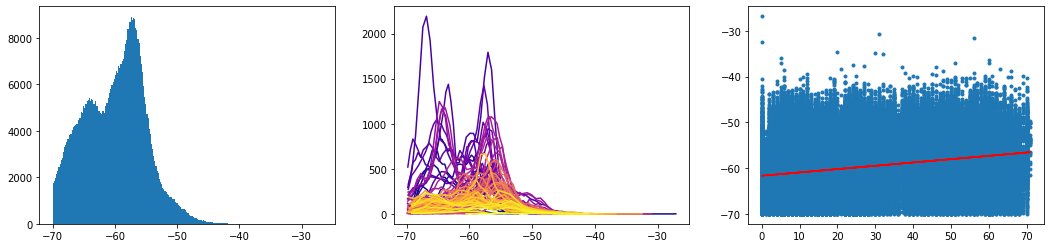

In [23]:
targetDist(pd.concat([df1022targets,df1023targets])) # targets from both 

Let's split it up by survey into survey 1 and 2, clean up 'bad' targets where there's no lat/lon values, and then also split up into the mini surveys by time.

In [24]:
dfSurvey1 = df1022targets[(df1022targets.index > '07-20-2018') & (df1022targets.index < '08-21-2018') ]
dfSurvey1.targetLon[(dfSurvey1.targetLon > 0)] = np.nan
dfSurvey1.targetLat[(dfSurvey1.targetLon > 0)] = np.nan
dfSurvey1.targetLon[(dfSurvey1.targetLat > 90)] = np.nan
dfSurvey1.targetLat[(dfSurvey1.targetLat > 90)] = np.nan
dfSurvey1.targetLon[(dfSurvey1.targetLat < -90)] = np.nan
dfSurvey1.targetLat[(dfSurvey1.targetLat < -90)] = np.nan
dfSurvey1.name = 'First Complete Survey'

df1023CS2 = df1023targets[(df1023targets.index > '08-24-2018 15:00:00') & (df1023targets.index < '09-07-2018')]
df1022CS2 = df1022targets[(df1022targets.index > '08-25-2018') & (df1022targets.index < '09-11-2018 22:00:00') ]
dfSurvey2 = pd.concat([df1023CS2, df1022CS2])
dfSurvey2.name = 'Second Complete Survey'

df1023targets.targetLon[(df1023targets.targetLon > 0)] = np.nan
df1023targets.targetLat[(df1023targets.targetLon > 0)] = np.nan
df1023targets.targetLon[(df1023targets.targetLat > 90)] = np.nan
df1023targets.targetLat[(df1023targets.targetLat > 90)] = np.nan
df1023targets.targetLon[(df1023targets.targetLat < -90)] = np.nan
df1023targets.targetLat[(df1023targets.targetLat < -90)] = np.nan

df1022targets.targetLon[(df1022targets.targetLon > 0)] = np.nan
df1022targets.targetLat[(df1022targets.targetLon > 0)] = np.nan
df1022targets.targetLon[(df1022targets.targetLat > 90)] = np.nan
df1022targets.targetLat[(df1022targets.targetLat > 90)] = np.nan
df1022targets.targetLon[(df1022targets.targetLat < -90)] = np.nan
df1022targets.targetLat[(df1022targets.targetLat < -90)] = np.nan

dfMLS1TS = df1023targets[(df1023targets.index > '07-20-2018 20:00:00') & (df1023targets.index < '08-04-2018 00:00:00')]
dfMLS1TS.name = 'MLS-1'
dfMLS2TS = df1022targets[(df1022targets.index > '07-23-2018 20:00:00') & (df1022targets.index < '08-13-2018 00:00:00')]
dfMLS2TS.name = 'MLS-2'
dfMLS3TS = pd.concat([df1023targets[(df1023targets.index > '08-13-2018 15:00:00') & (df1023targets.index < '08-16-2018 20:00:00')], df1022targets[(df1022targets.index > '08-22-2018 00:00:00') & (df1022targets.index < '08-29-2018 00:00:00')]])
dfMLS3TS.name = 'MLS-3'
dfMLS4TS = df1023targets[(df1023targets.index > '08-30-2018 20:00:00') & (df1023targets.index < '09-11-2018 17:00:00')]
dfMLS4TS.name = 'MLS-4'

In [25]:
print('There are '+str(len(dfMLS1TS))+' targets in the 1 dataset')
print('There are '+str(len(dfMLS2TS))+' targets in the 2 dataset')
print('There are '+str(len(dfMLS3TS))+' targets in the 3 dataset')
print('There are '+str(len(dfMLS4TS))+' targets in the 4 dataset')
sum([len(dfMLS1TS),len(dfMLS2TS),len(dfMLS3TS),len(dfMLS4TS)])

There are 60780 targets in the 1 dataset
There are 149740 targets in the 2 dataset
There are 27727 targets in the 3 dataset
There are 14702 targets in the 4 dataset


252949

## Look at change in the TS over the time of the 4 mini-surveys

In [26]:
dfMLS1TS = dfMLS1TS[dfMLS1TS.targetTS <=-40]
dfMLS2TS = dfMLS2TS[dfMLS2TS.targetTS <=-40]
dfMLS3TS = dfMLS3TS[dfMLS3TS.targetTS <=-40]
dfMLS4TS = dfMLS4TS[dfMLS4TS.targetTS <=-40]

Mean TS: -57.3 Length: 3.5 Median TS: -58.1 Min TS: -70.0 Max TS: -40.2 Length: 3.5
Mean TS: -58.1 Length: 3.1 Median TS: -60.0 Min TS: -70.0 Max TS: -40.1 Length: 3.1
Mean TS: -56.0 Length: 4.3 Median TS: -57.2 Min TS: -70.0 Max TS: -42.1 Length: 4.3
Mean TS: -55.8 Length: 4.5 Median TS: -57.1 Min TS: -70.0 Max TS: -40.7 Length: 4.5


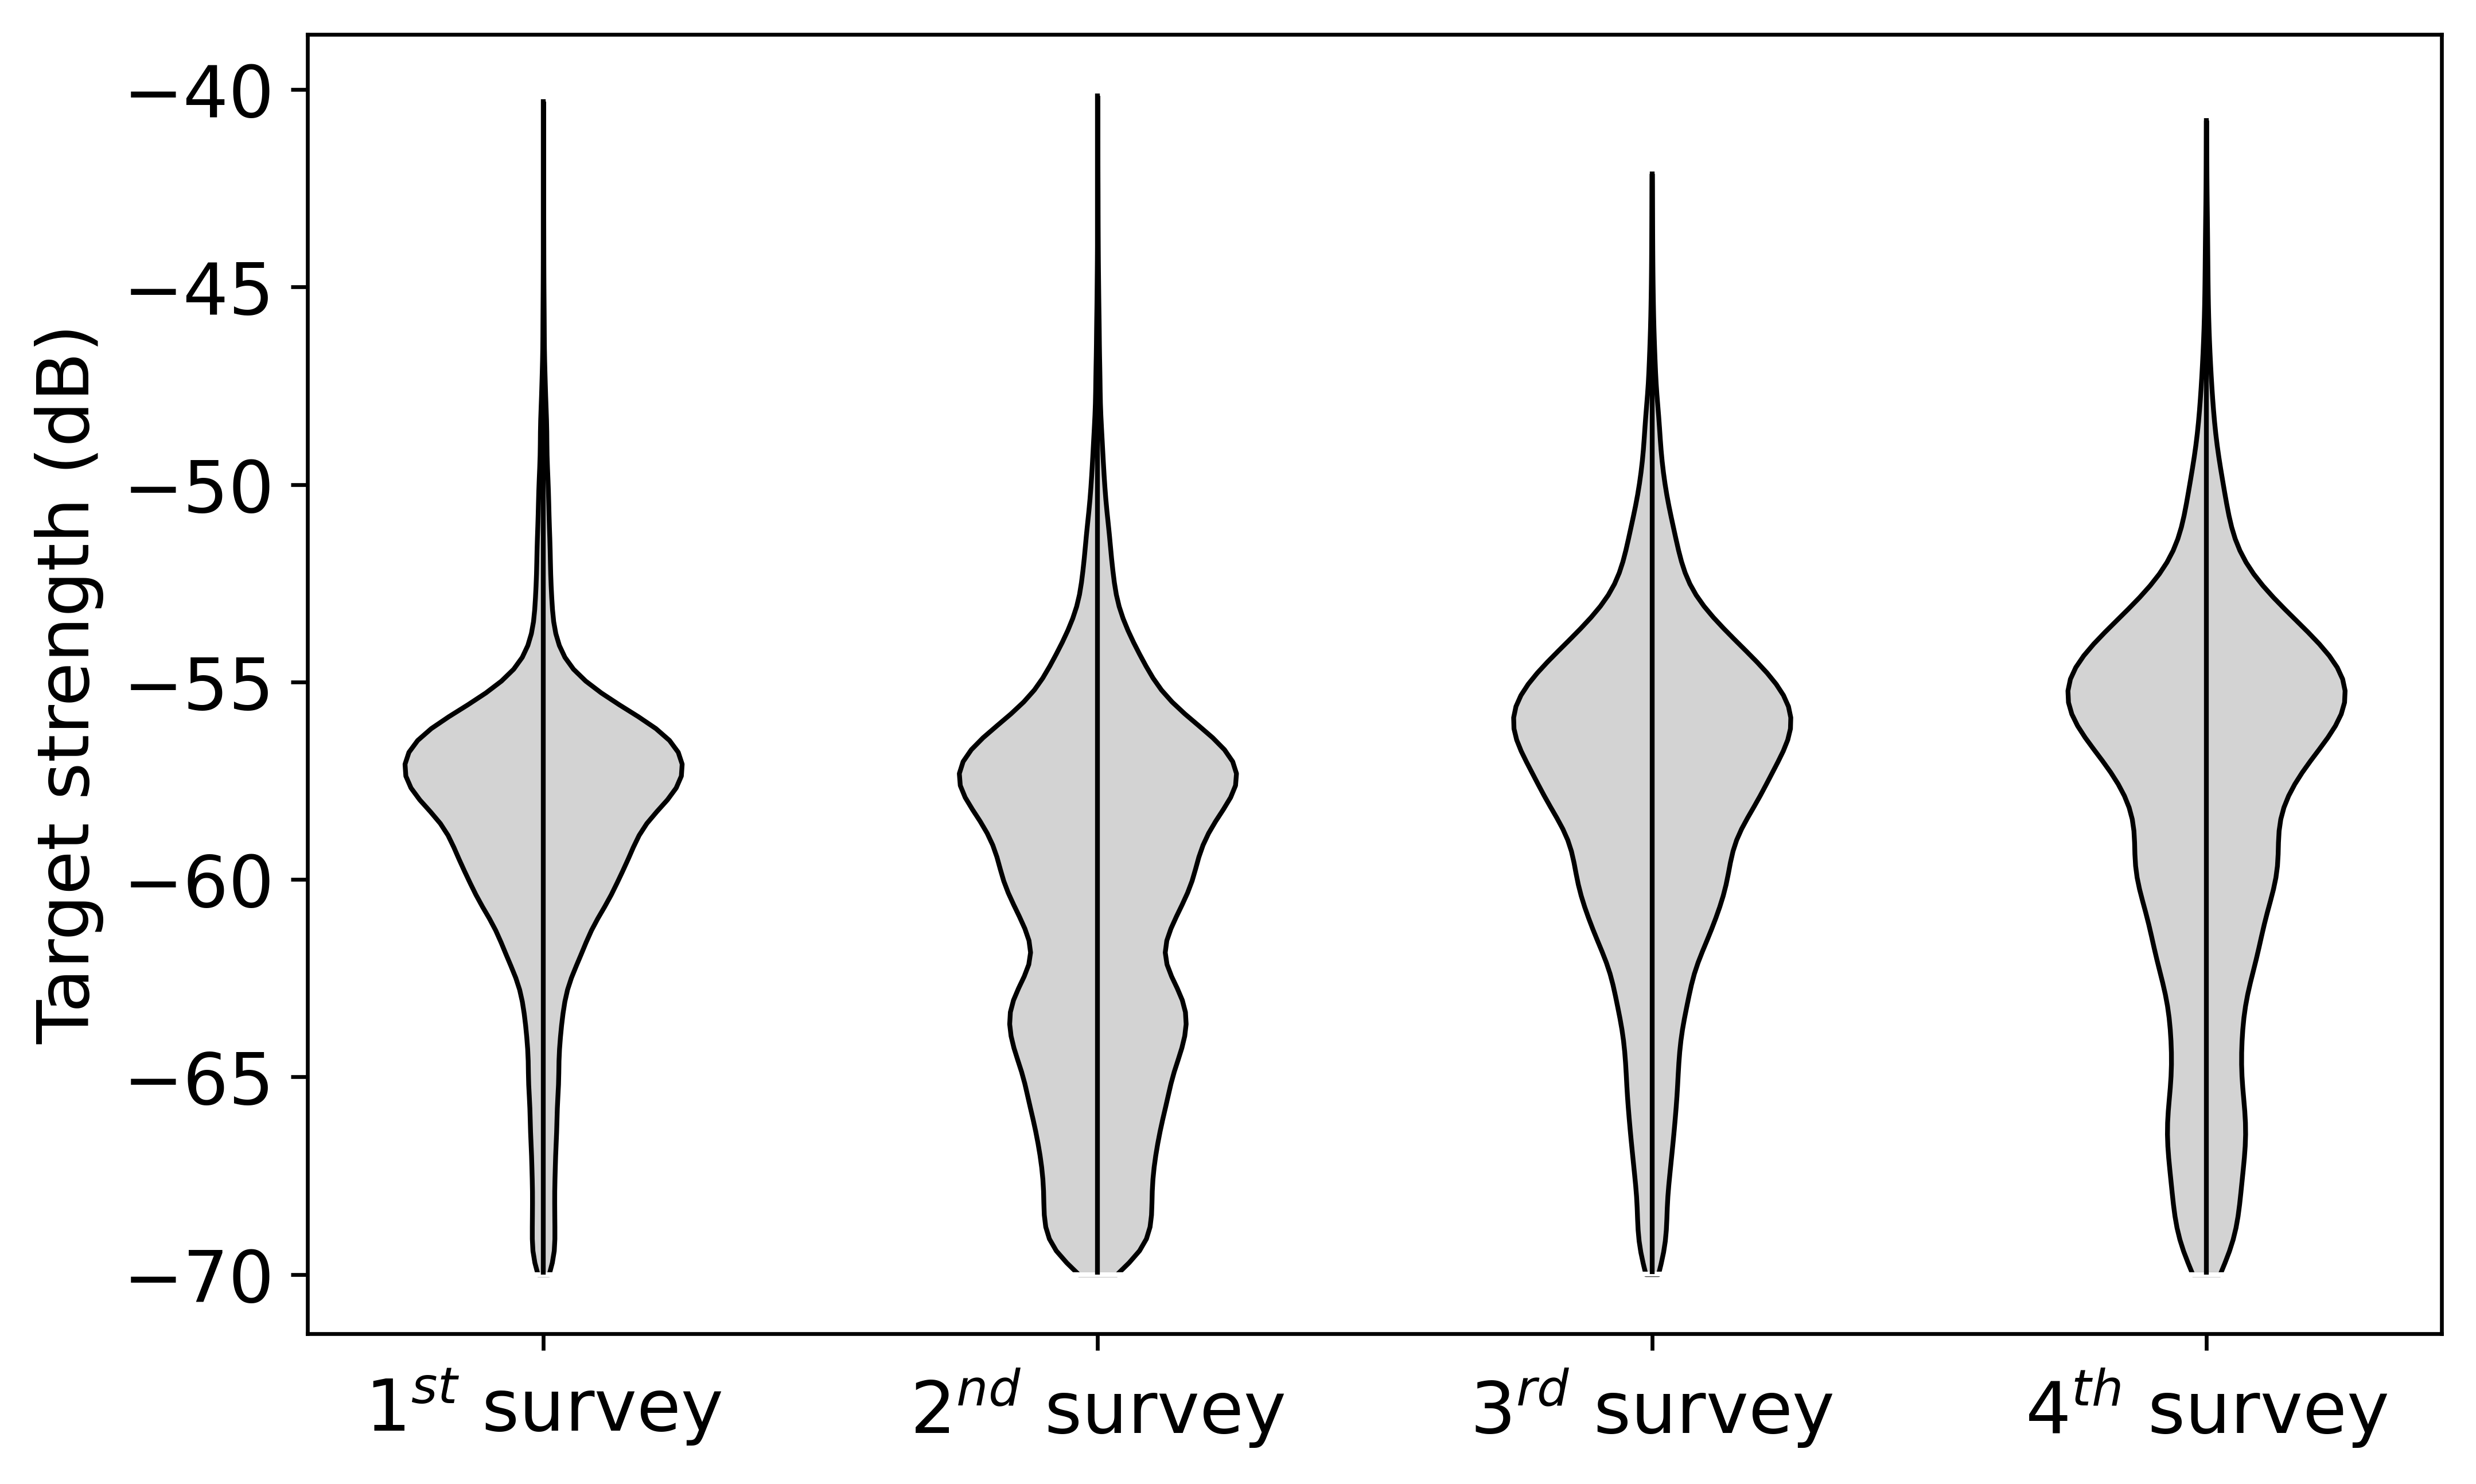

In [27]:
means = [10*np.log10(np.mean(dfMLS1TS.linearTS)),10*np.log10(np.mean(dfMLS2TS.linearTS)),10*np.log10(np.mean(dfMLS3TS.linearTS)),10*np.log10(np.mean(dfMLS4TS.linearTS))]
medians = [10*np.log10(np.median(dfMLS1TS.linearTS)),10*np.log10(np.median(dfMLS2TS.linearTS)),10*np.log10(np.median(dfMLS3TS.linearTS)),10*np.log10(np.median(dfMLS4TS.linearTS))]
mins = [10*np.log10(np.min(dfMLS1TS.linearTS)),10*np.log10(np.min(dfMLS2TS.linearTS)),10*np.log10(np.min(dfMLS3TS.linearTS)),10*np.log10(np.min(dfMLS4TS.linearTS))]
maxs = [10*np.log10(np.max(dfMLS1TS.linearTS)),10*np.log10(np.max(dfMLS2TS.linearTS)),10*np.log10(np.max(dfMLS3TS.linearTS)),10*np.log10(np.max(dfMLS4TS.linearTS))]

[print('Mean TS:',   round(means[i],1),'Length:',round(geoffroyTS(means[i]),1), 'Median TS:',   round(medians[i],1),'Min TS:',   round(mins[i],1),'Max TS:',   round(maxs[i],1),'Length:',round(geoffroyTS(means[i]),1)) for i in range(len(means))]


rcParams.update({'font.size': 15})
a = [dfMLS1TS.targetTS,dfMLS2TS.targetTS,dfMLS3TS.targetTS,dfMLS4TS.targetTS]
fig = plt.figure(figsize=(8,5),dpi=600)
ax1 = plt.subplot(111)
parts = ax1.violinplot(a)
for pc in parts['bodies']:
    pc.set_facecolor('lightgrey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
for partname in('cmins','cmaxes'):# ('cbars','cmins','cmaxes'):
    vp = parts[partname]
    vp.set_edgecolor('w')
    vp.set_linewidth(1)
vp = parts['cbars']
vp.set_edgecolor('k')
vp.set_linewidth(1)
ax1.set_ylabel('Target strength (dB)')
ax1.xaxis.set_major_locator(plt.MultipleLocator(1))
ax1.set_xticklabels(['','1$^{st}$ survey','2$^{nd}$ survey','3$^{rd}$ survey','4$^{th}$ survey']);

In [23]:
10**(-55.1/10)/10**(-56.8/10)

1.4791083881682072

Text(0.81, 0.92, '4$^{th}$ survey')

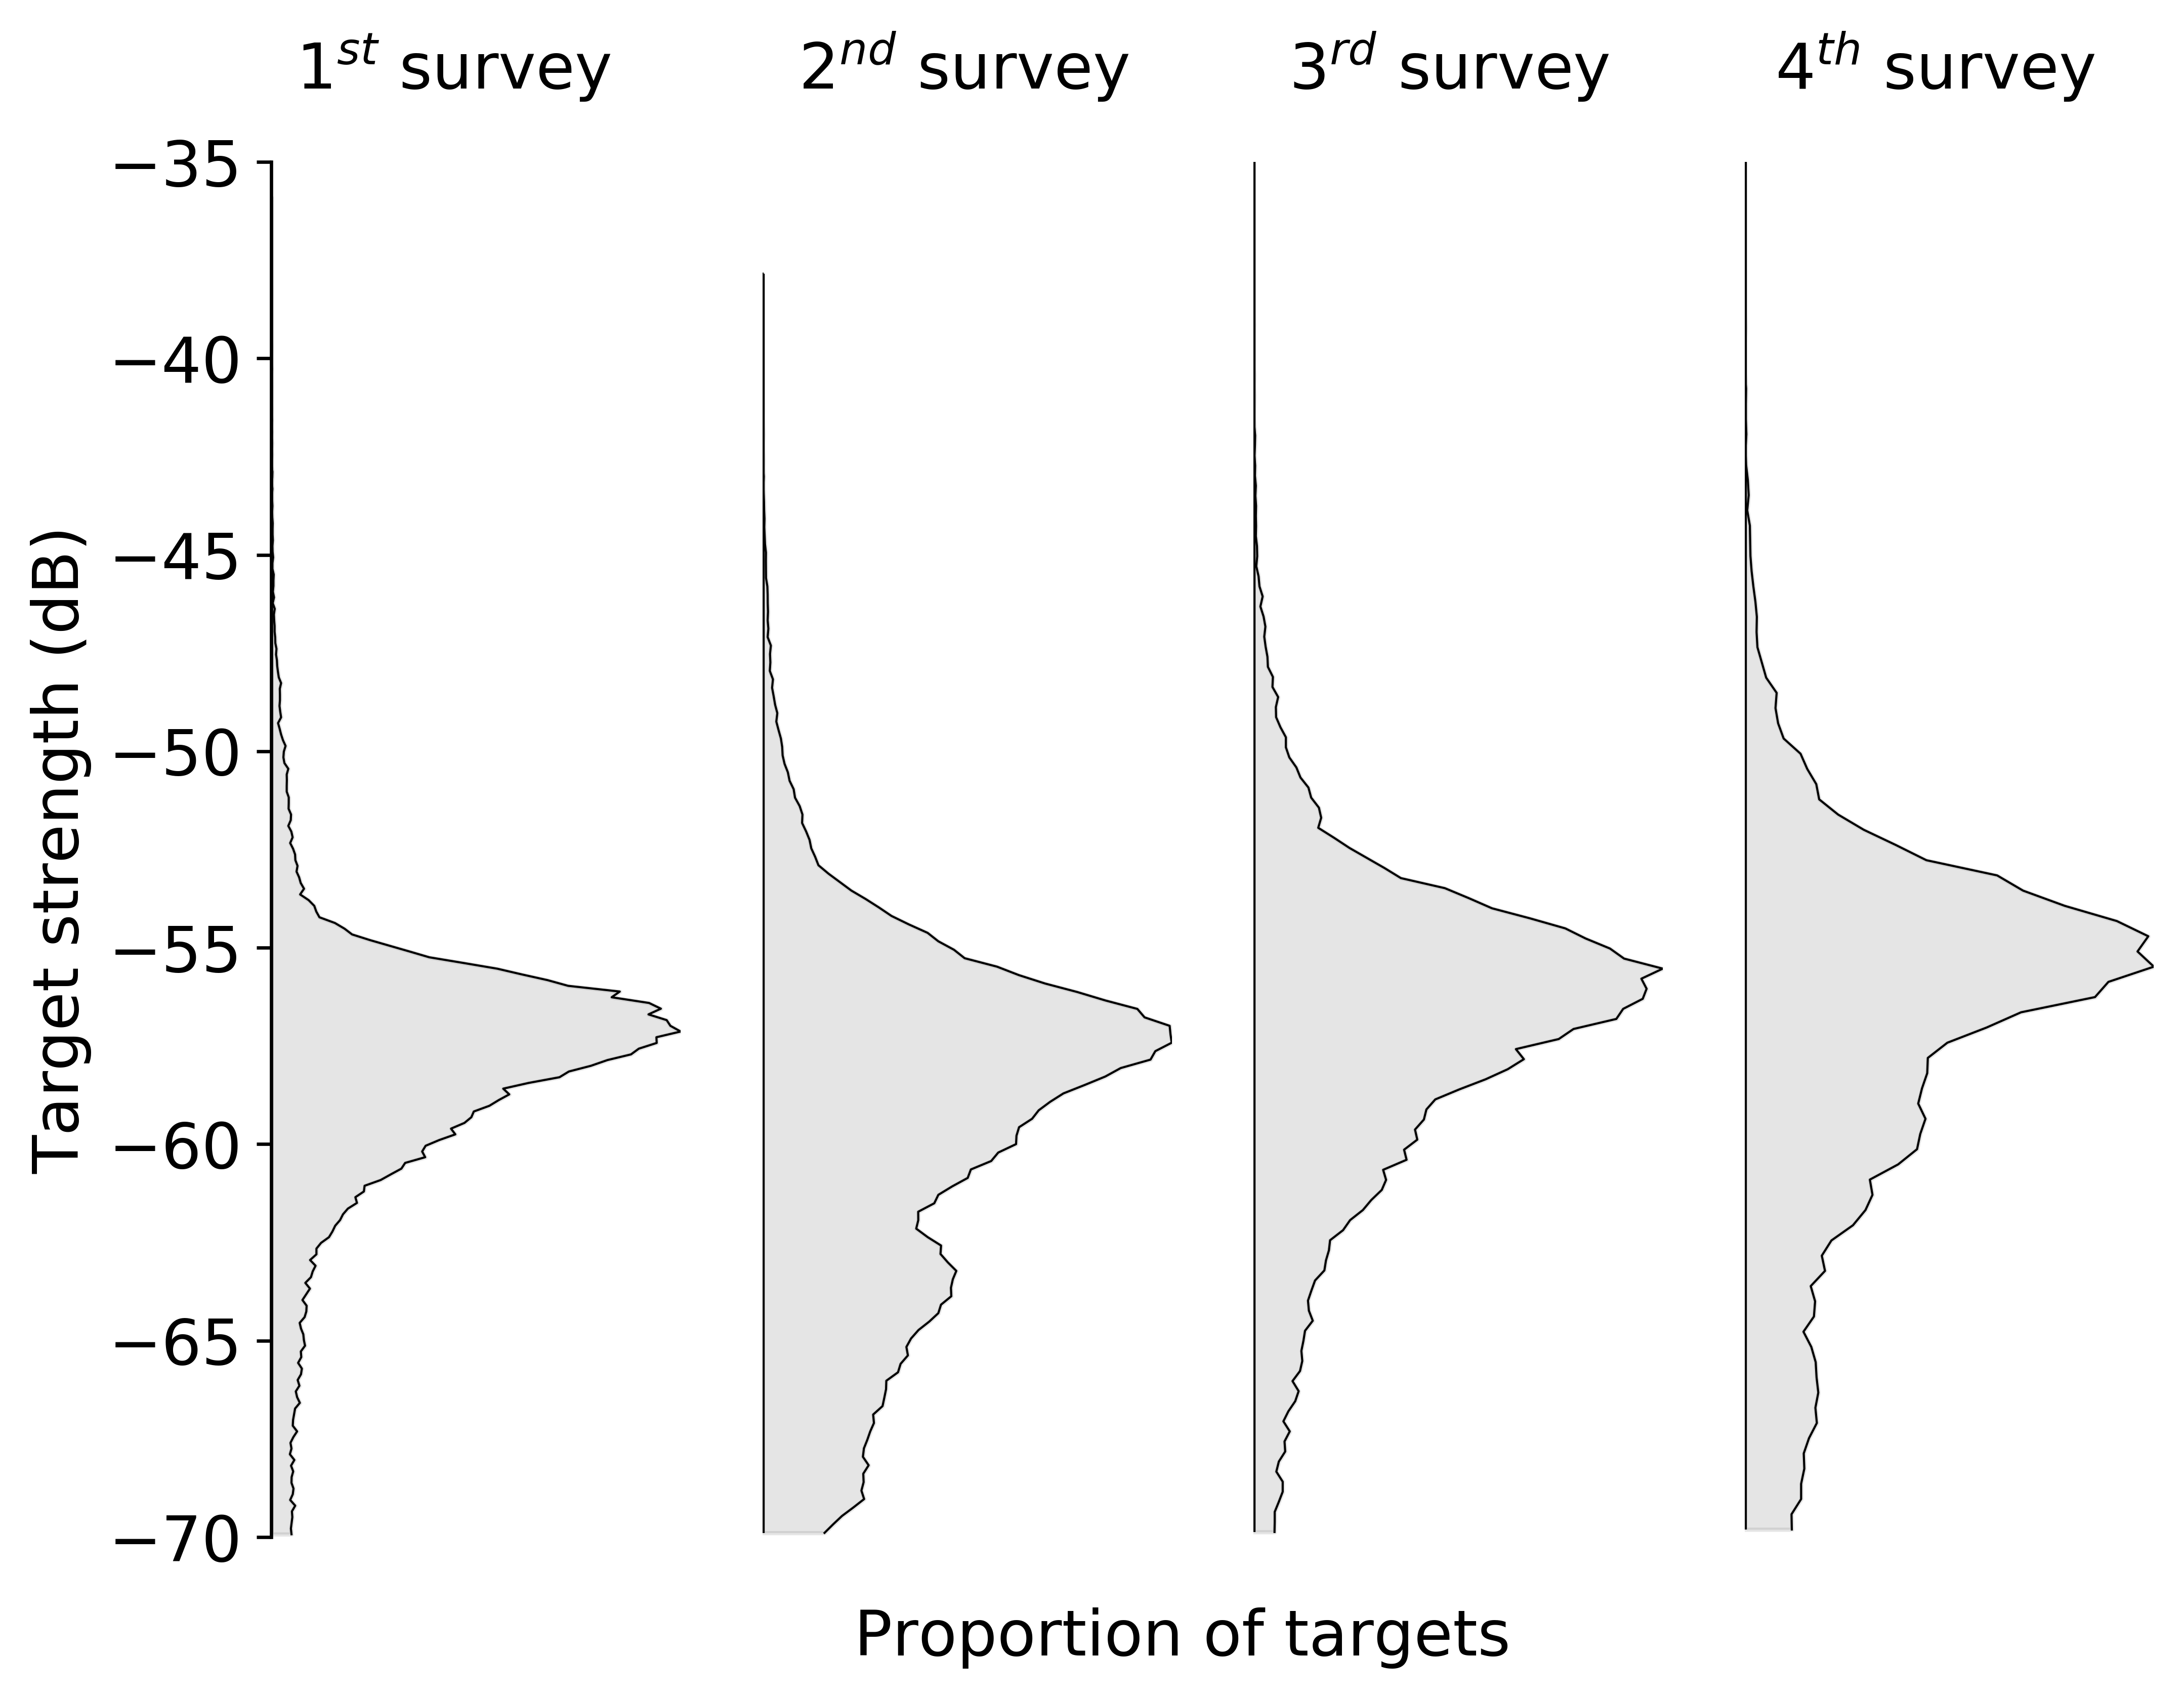

In [6]:
rcParams.update({'font.size': 15})
fig= plt.figure(figsize=(8,6), dpi=600)
ct =1
for df in [dfMLS1TS,dfMLS2TS,dfMLS3TS,dfMLS4TS]:
        n,x  = np.histogram(df.targetTS, bins='auto');
        bin_centers = 0.5*(x[1:]+x[:-1])
        plt.subplot(1,4,ct)
        plt.plot(n/sum(n),bin_centers, color='k', linewidth=.5)
#        plt.plot(-1*n/sum(n),bin_centers, color='k', linewidth= .2)
        plt.fill_betweenx(bin_centers,0,n/sum(n), color = 'grey', alpha = 0.2)
        plt.axis([0, max(n/sum(n)),-70,-35])
        plt.gca().set_xticks([])
        if ct ==1:
            plt.ylabel('Target strength (dB)')
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
        else:
            plt.vlines(0,min(bin_centers), max(bin_centers), color='k', linewidth=1)
            plt.gca().set_yticklabels([])
            plt.gca().set_yticks([])
            plt.gca().axis('off')
        ct+=1
#        plt.fill_between(-1*n/sum(n),np.min(bin_centers),bin_centers, color = 'grey', alpha = 0.5))
fig.text(0.5, 0.06, 'Proportion of targets', ha='center')
fig.text(0.2, .92,'1$^{st}$ survey',ha='center')
fig.text(0.41, .92,'2$^{nd}$ survey',ha='center')
fig.text(0.61, .92,'3$^{rd}$ survey',ha='center')
fig.text(0.81, .92,'4$^{th}$ survey',ha='center')
         #'2$^{nd}$ survey','3$^{rd}$ survey','4$^{th}$ survey']);

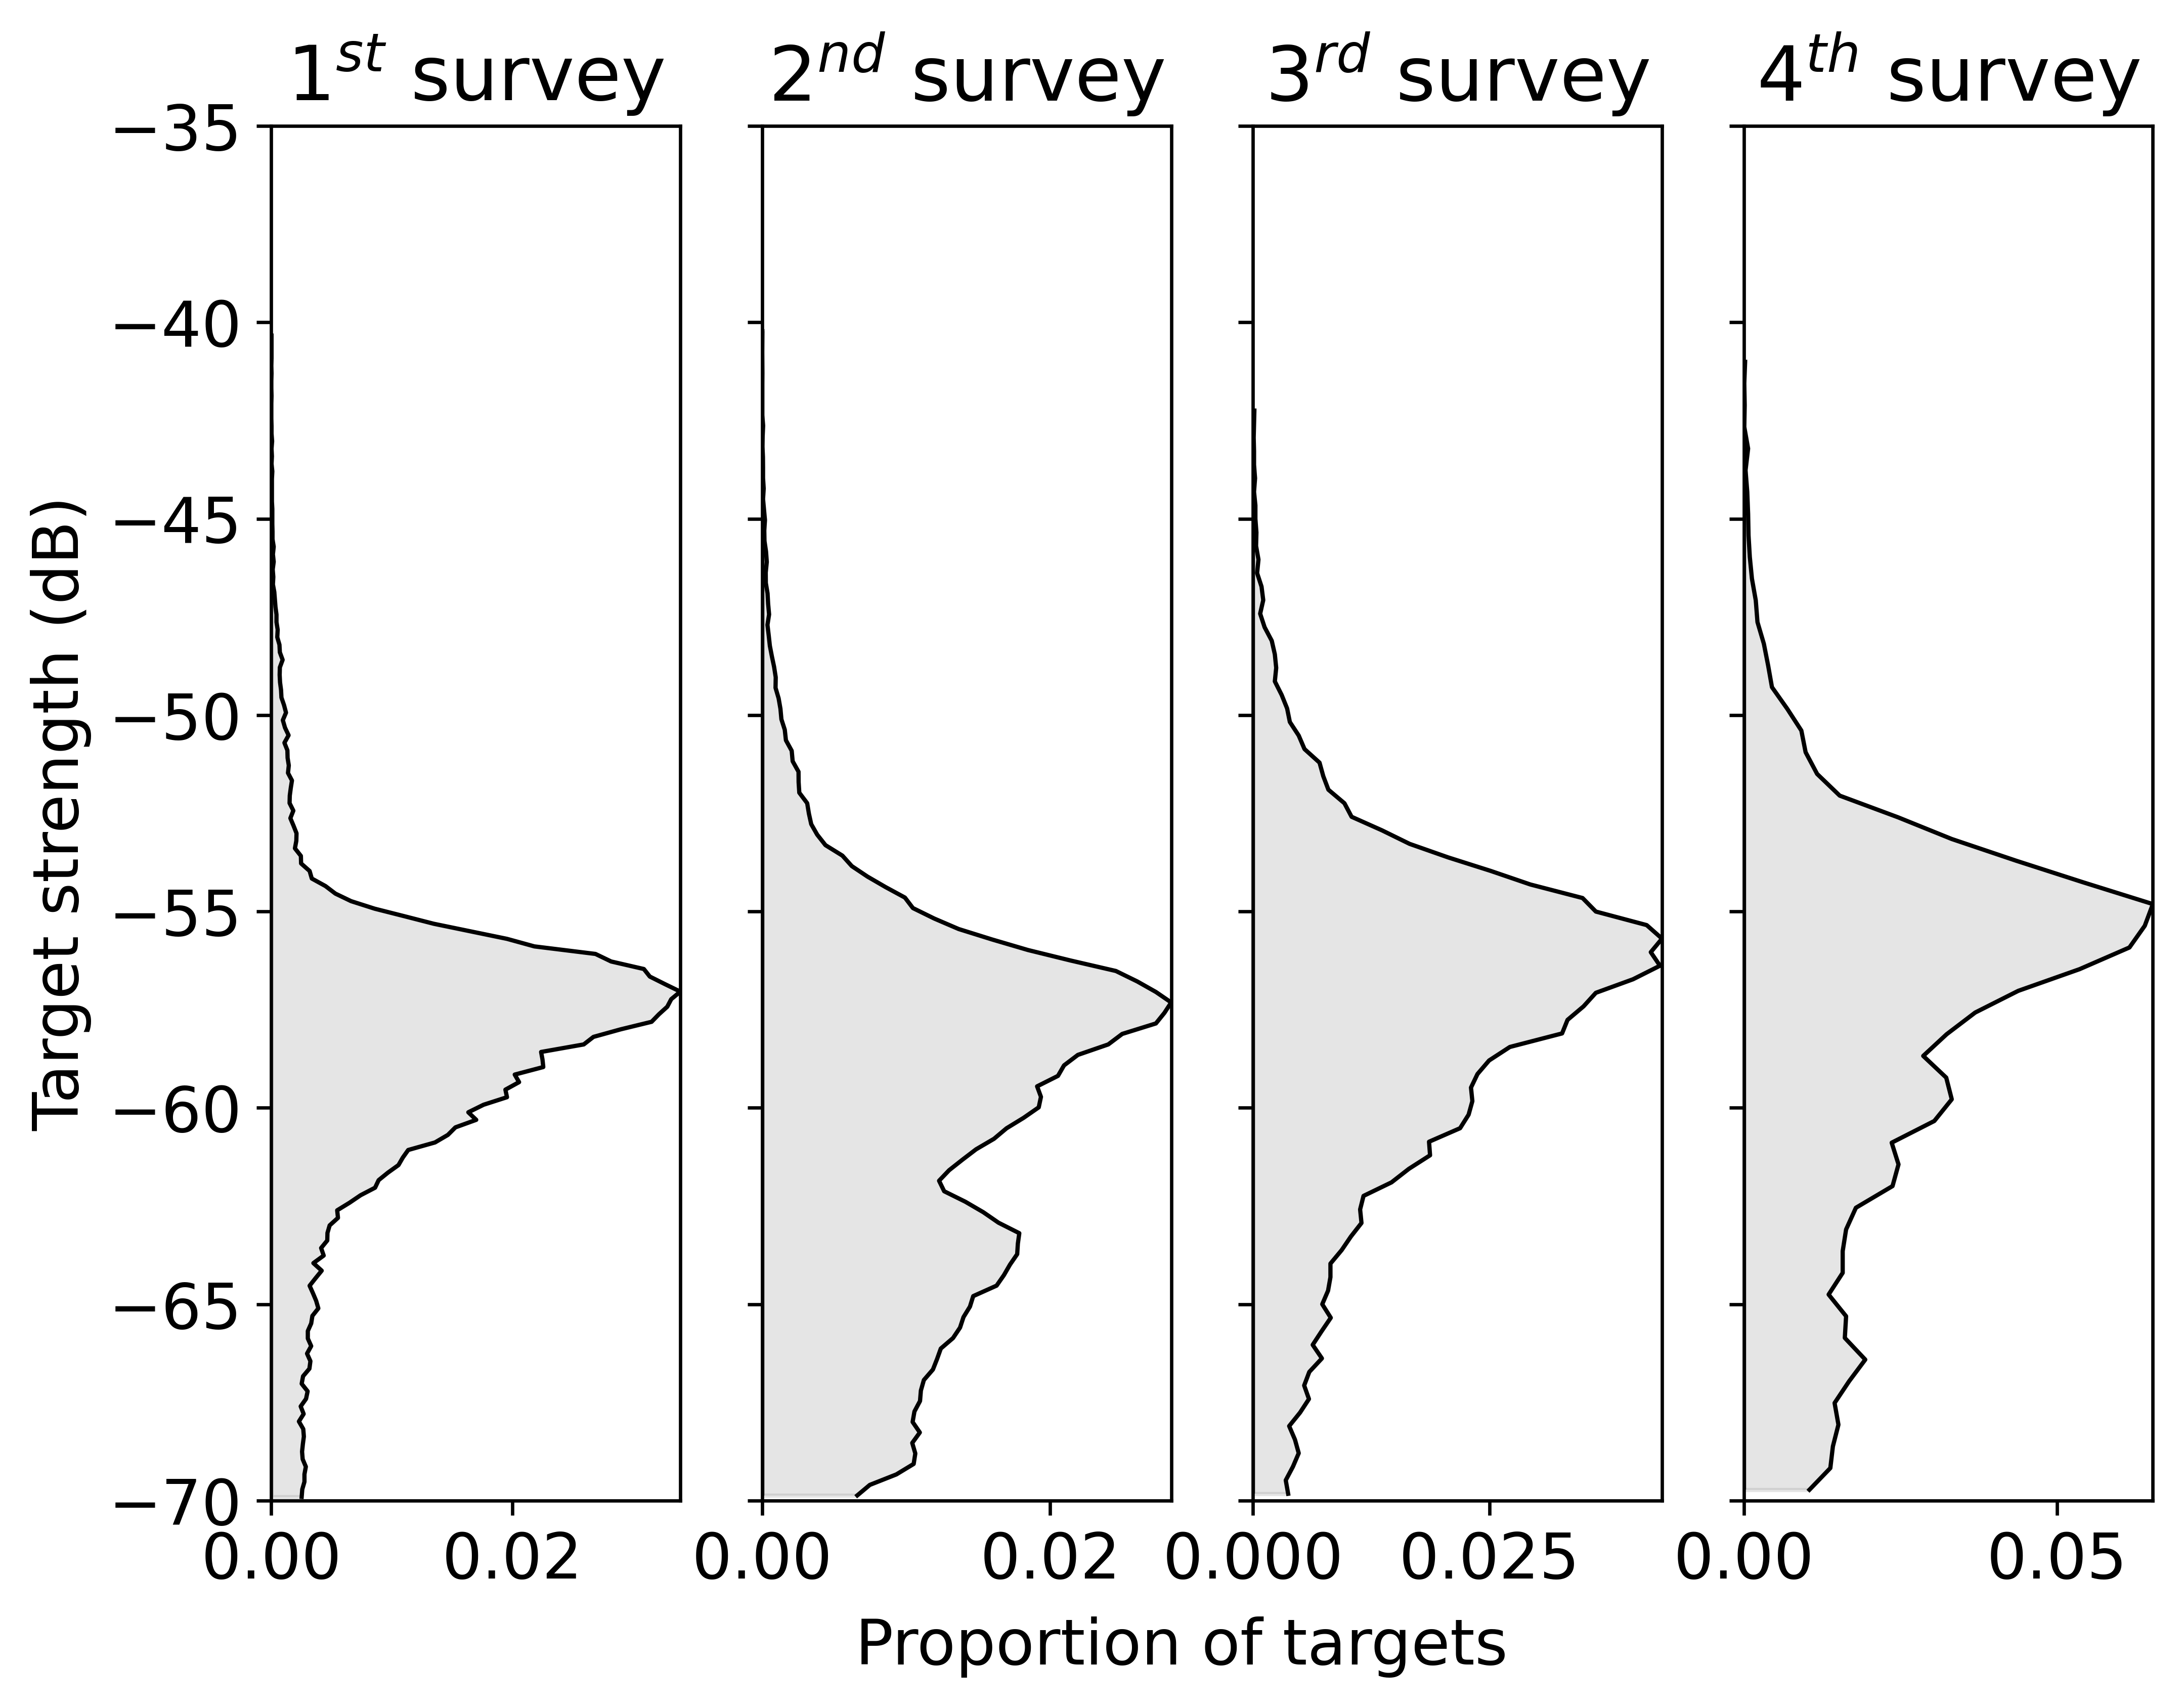

In [28]:
rcParams.update({'font.size': 15})
fig= plt.figure(figsize=(8,6), dpi=600)
ct =1
titles = ['1$^{st}$ survey','2$^{nd}$ survey','3$^{rd}$ survey','4$^{th}$ survey']
for df in [dfMLS1TS,dfMLS2TS,dfMLS3TS,dfMLS4TS]:
        n,x  = np.histogram(df.targetTS, bins='auto');
        bin_centers = 0.5*(x[1:]+x[:-1])
        plt.subplot(1,4,ct)
        plt.plot(n/sum(n),bin_centers, color='k', linewidth=1)
#        plt.plot(-1*n/sum(n),bin_centers, color='k', linewidth= .2)
        plt.fill_betweenx(bin_centers,0,n/sum(n), color = 'grey', alpha = 0.2)
        plt.axis([0, max(n/sum(n)),-70,-35])
        #plt.gca().set_xticks([])
        plt.title(titles[ct-1])
        if ct ==1:
            plt.ylabel('Target strength (dB)')
            #plt.gca().spines['right'].set_visible(False)
            #plt.gca().spines['top'].set_visible(False)
            #plt.gca().spines['bottom'].set_visible(False)
        else:
            plt.vlines(0,min(bin_centers), max(bin_centers), color='k', linewidth=1)
            plt.gca().set_yticklabels([])
            #plt.gca().set_yticks([])
            #plt.gca().axis('off')
        ct+=1
#        plt.fill_between(-1*n/sum(n),np.min(bin_centers),bin_centers, color = 'grey', alpha = 0.5))
fig.text(0.5, 0.035, 'Proportion of targets', ha='center');
#fig.text(0.2, .92,'1$^{st}$ survey',ha='center')
#fig.text(0.41, .92,'2$^{nd}$ survey',ha='center')
#fig.text(0.61, .92,'3$^{rd}$ survey',ha='center')
#fig.text(0.81, .92,'4$^{th}$ survey',ha='center')
#plt.savefig("G:/My Drive/Research/Arctic EIS II/Saildrone/manuscript/Final/figsUnfiltered/Submitted/svg/F6_2.svg")

Ok, so lets just check if we can figure out density.  The equation is p = NASC/(4)(pi)(sigmabs).  The NASC values we have from the 4 surveys come from the survey38FiltAcousticData notebook:
- survey 1: 200.28926857553512
- survey 2: 161.01326669990863
- survey 3: 206.98639985458382
- survey 4: 358.82048074314866

In [29]:
import numpy as np
def fishDens(NASC, TS):
    dens = NASC/(4*np.pi*(10**(TS/10)))
    dens = dens*(1/3429904) # convers from nmi2 to m2
    return round(dens,3)
#print('in fish per m^2',fishDens(200-26, -57.19), fishDens(161-22,-57.27), fishDens(206-29,-55.009), fishDens(358-52,-54.13))
#print('in fish per m^2',fishDens(200, -56), fishDens(161,-55.6), fishDens(206,-53.1), fishDens(358,-52.2))
#print('in fish per m^2',fishDens(200+26, -57.19), fishDens(161+22,-57.27), fishDens(206+29,-55.009), fishDens(358+52,-54.13))

#print('in fish per m^2',fishDens(200-26, means[0]), fishDens(161-22,means[1]), fishDens(206-29,means[2]), fishDens(358-52,means[3]))
#print('in fish per m^2',fishDens(200, means[0]), fishDens(161,means[1]), fishDens(206,means[2]), fishDens(358,means[3]))
#print('in fish per m^2',fishDens(200+26, means[0]), fishDens(161+22,means[1]), fishDens(206+29,means[2]), fishDens(358+52,means[3]))

print('in fish per m^2',fishDens(197-53, means[0]), fishDens(177-76,means[1]), fishDens(281-79,means[2]), fishDens(369-80,means[3]))
print('in fish per m^2',fishDens(197, means[0]), fishDens(177,means[1]), fishDens(281,means[2]), fishDens(369,means[3]))
print('in fish per m^2',fishDens(197+53, means[0]), fishDens(177+76,means[1]), fishDens(281+79,means[2]), fishDens(369+80,means[3]))

in fish per m^2 1.783 1.53 1.864 2.526
in fish per m^2 2.44 2.682 2.593 3.225
in fish per m^2 3.096 3.834 3.322 3.925
